# Подбор параметров nucleus-самплинга, с которыми вероятнее всего получение правильного следующего токена



In [1]:
import torch
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModelWithLMHead
import pandas as pd
import json
from tqdm import tqdm
from typing import List, Dict
import re
from statistics import mean
from copy import copy
from tqdm import tqdm
tqdm.pandas()

In [1]:
import sys
sys.path.append('..')

In [3]:
TEST_DF_PATH = '../data/test_prompts.csv'

In [4]:
test_df = pd.read_csv(TEST_DF_PATH)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from generation.init_tokenizer import init_kremlin_tokenizer
from generation.load_model import load_kremlin_gpt

In [8]:
tokenizer = init_kremlin_tokenizer()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
gpt = load_kremlin_gpt()

Лучшие параметры самплинга для конкретного случая - такие, когда правильный токен последний из рассматриваемых (если ограничения более строгие, он никогда не будет выбран, если менее строгие - он может быть выбран, но с меньшей вероятностью)

In [ ]:
# функция была откуда-то скопирована, но давно и не мной, не помню источник и поэтому не могу сослаться
def best_k_p(logits:torch.tensor, golden:torch.tensor):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
    ks = (sorted_indices == golden).nonzero()[:, 1]
    ps = cumulative_probs[sorted_indices == golden]
    return ks, ps

In [ ]:
all_best_ks, all_best_ps = [], []

for prompt in tqdm(list(test_df['prompt'])):
    encoding = tokenizer([prompt], return_tensors='pt').to(gpt.device)
    input_ids = encoding['input_ids']
    with torch.no_grad():
         logits = gpt(**encoding).logits
    # считаем параметры для всех токенов, кроме нулевого
    for token_idx in range(input_ids.shape[-1]-1):
        # по логиту предыдущего токена нужно с наивысшим качеством предсказывать следующий
        logit = logits[:, token_idx, :]
        gold = input_ids[:, token_idx+1]
        current_best_k, current_best_p = best_k_p(logit, gold)
        all_best_ks.append(current_best_k.item())
        all_best_ps.append(current_best_p.item())
    

100%|██████████| 127/127 [00:11<00:00, 10.68it/s]


In [ ]:
pd.Series(all_best_ks).describe()

count    22048.000000
mean        38.990566
std        361.709193
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max      21059.000000
dtype: float64

In [ ]:
pd.Series(all_best_ps).describe()

count    22048.000000
mean         0.924812
std          0.142089
min          0.123641
25%          0.925858
50%          0.993348
75%          0.999725
max          1.000000
dtype: float64

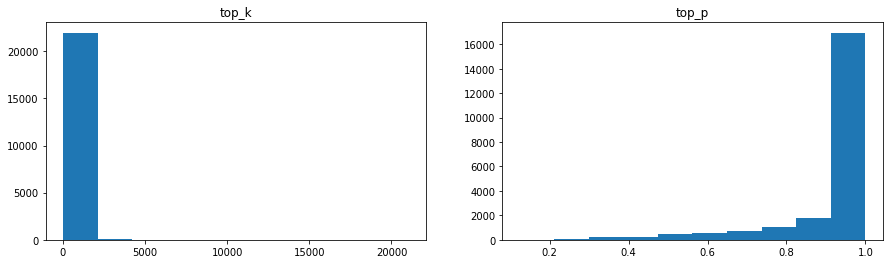

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 4]

plt.subplot(1, 2, 1)
plt.hist(all_best_ks)
plt.title('top_k')
plt.subplot(1, 2, 2)
plt.hist(all_best_ps)
plt.title('top_p')
plt.show()

Судя по распределению лучших top_k, лучшие параметры nucleus-самплинга близки к жадной генерации. То, что значения выше 0 наблюдаются только на 75-м перцентиле, подозрительно, но может быть связано с тем, что 

Если затравка генерации включает в себя фрагменты текста, которые нужно повторить, это ожидаемо.


# Генерация с разными параметрами

Сгенерирую тексты разными способами: жадно генерацией, beam search, nucleus_sampling с разными параметрами

In [11]:
universal_parameters = {
    'min_length': 50,
    'max_length':250,
    # не позволяет модели генерировать падинги перед текстом и генерировать текст, реальная длина которого меньше заданной
    'bad_words_ids':[[tokenizer.pad_token_id]],
    'eos_token_id':tokenizer.eos_token_id,
    # параметр нужен исключительно чтобы избежать большого количества логов "Setting `pad_token_id` to `eos_token_id`"
    'pad_token_id':tokenizer.eos_token_id
}


In [12]:
method2generation_parameters = {
    'greedy':{},
    'beam_search_5beams': {'num_beams':5},
    'top_p_0.97': {'do_sample':True, 'top_p': 0.97},
    'top_p_0.9': {'do_sample':True, 'top_p':0.9},
    'top_k_3': {'do_sample':True, 'top_k':3},
    'top_k_15':{'do_sample':True, 'top_k':15},
    'top_p_0.9_temp1.5': {'do_sample':True, 'top_p':0.9, 'temperature':1.5},
    'top_k_15_temp1.5':{'do_sample':True, 'top_k':15, 'temperature':1.5}
}

Так как нужно, чтобы модель повторяла название сущностей, repetition_penalty не настраиваю (иначе я буду штрафовать модель не только за зацикливание, но и за правильное выполнение поставленной перед ней задачи). Можно попробовать написать написать кастомный самплер, игнорирующий заданные сущности при подсчете repetition_penalty, но это займет много времени и в рамках тестового задания я это делать не буду

In [ ]:
def generate(prompt, generation_method):
    if generation_method not in method2generation_parameters:
        raise ValueError('unknown generation method')
    input = tokenizer([prompt], return_tensors='pt').to(gpt.device)
    input.update(universal_parameters)
    input.update(method2generation_parameters[generation_method])
    output = gpt.generate(**input)
    return tokenizer.decode(output[0].tolist())

In [7]:
from generation.tags import TITLE_TAG

In [8]:
TITLE_TAG

'TITLE'

In [9]:
def get_input_text(correct_formatted_text, separator_tag=TITLE_TAG):
    return correct_formatted_text.split(separator_tag)[0]+separator_tag

In [ ]:
test_df['prompt_beginning'] = test_df['prompt'].apply(get_input_text)

In [ ]:
for column in ['title_ner', 'text_ner', 'selected_entities']:
    test_df[column] = test_df[column].apply(json.dumps)

In [ ]:
for method in method2generation_parameters:
    print(method)
    test_df[method] = test_df['prompt_beginning'].progress_apply(lambda x: generate(x, method))
    test_df.to_csv(TEST_DF_PATH, index=False)

greedy


100%|██████████| 127/127 [02:59<00:00,  1.41s/it]


beam_search_5beams


100%|██████████| 127/127 [04:17<00:00,  2.03s/it]


top_p_0.97


100%|██████████| 127/127 [03:17<00:00,  1.55s/it]


top_p_0.9


100%|██████████| 127/127 [03:17<00:00,  1.55s/it]


top_k_3


100%|██████████| 127/127 [02:50<00:00,  1.34s/it]


top_k_15


100%|██████████| 127/127 [03:22<00:00,  1.59s/it]


top_p_0.9_temp1.5


100%|██████████| 127/127 [03:50<00:00,  1.81s/it]


top_k_15_temp1.5


100%|██████████| 127/127 [03:40<00:00,  1.73s/it]


In [81]:
for method in method2generation_parameters:
    print(method)
    print(test_df[method].loc[0])
    print('________')

greedy
BOS PER ORG Геральдический совет, Геральдический совет TITLE Коллективу и ветеранам Геральдического совета TEXT Дорогие друзья! Поздравляю вас с 75-летием создания Геральдического совета. За прошедшие годы Геральдический совет вырос в крупное, авторитетное общественное объединение, которое объединяет представителей самых разных сословий, представителей разных поколений. Важно, что вы бережно храните традиции своих предшественников, стремитесь эффективно решать поставленные задачи, вносить значимый вклад в развитие отечественной культуры и искусства, в укрепление международного гуманитарного сотрудничества. И конечно, важно, что вы уделяете неустанное внимание реализации востребованных благотворительных, образовательных, просветительских инициатив, уделяете неустанное внимание реализации востребованных благотворительных, образовательных, просветительских инициатив, уделяете неустанное внимание реализации востребованных благотворительных, образовательных, просветительских инициати

In [82]:
for method in method2generation_parameters:
    print(method)
    print(test_df[method].loc[1])
    print('________')

greedy
BOS PER ORG Серовского исторического музея TITLE Коллективу Серовского исторического музея TEXT Дорогие друзья! Поздравляю вас с 75-летием Серовского исторического музея. История Серовского исторического музея тесно связана с именами выдающихся учёных, писателей, художников, которые внесли значимый вклад в развитие отечественной культуры, в укрепление её исторического, культурного, духовного потенциала. Важно, что вы бережно храните богатейшее собрание раритетов, которые по праву считаются бесценными памятниками отечественной культуры, которые по праву считаются бесценными достоянием нашего народа. И конечно, важно, что вы уделяете неустанное внимание развитию музейного дела, уделяете неустанное внимание популяризации музейных коллекций, их пополнению экспозициями, рассказывающими об истории родного края, его замечательных традициях и обычаях. Желаю вам успехов и всего наилучшего. EOS
________
beam_search_5beams
BOS PER ORG Серовского исторического музея TITLE Коллективу и ветер

In [83]:
for method in method2generation_parameters:
    print(method)
    print(test_df[method].loc[2])
    print('________')

greedy
BOS PER Генриху Боровику ORG TITLE Патриарху Московскому и всея Руси Кириллу TEXT Ваше Святейшество! Примите сердечные поздравления по случаю Вашего 80-летнего юбилея. Вы по праву пользуетесь высоким авторитетом среди верующих, своим подвижническим служением содействуете укреплению межрелигиозного и межнационального диалога, развитию межконфессиональных и межконфессиональных отношений. И конечно, особо отмечу Ваше активное участие в жизни Русской православной церкви, в укреплении института семьи, воспитании подрастающего поколения. Желаю Вам здоровья, успехов и всего наилучшего. EOS
________
beam_search_5beams
BOS PER Генриху Боровику ORG TITLE Патриарху Московскому и всея Руси Кириллу TEXT Ваше Святейшество! Примите сердечные поздравления с Днём Вашего тезоименитства. Ваше Святейшество! Сердечно поздравляю Вас с Днём Вашего тезоименитства. Ваше Святейшество! Сердечно поздравляю Вас с Днём Вашего тезоименитства. Ваше Святейшество! Сердечно поздравляю Вас с Днём Вашего тезоименит

С организациями модель справилась, с Генрихом Боровиком - нет (только в одном случае сущность повторена, причем от увеличения top_k и температуры обычно ожидается понижение способности повторять заданные ключевые слова.

Оценим качество генерации метриками, однако нужно учесть, что на тестовой выборке мы можем оценить только качество генерации для стандартных тематик, на которые действительно существуют поздравления президента

# Метрики

In [11]:
from generation.postprocessing import get_title_and_text

In [ ]:
for column in ['title_ner', 'text_ner', 'selected_entities']:
    test_df[column] = test_df[column].apply(json.loads)

In [14]:
for column in ['title_ner', 'text_ner', 'selected_entities']:
    test_df[column] = test_df[column].apply(json.loads)

In [42]:
from metrics import corpus_entity_representation_proba

In [12]:
def add_extracted_text_columns(row, method):
    title, text = get_title_and_text(row[method])
    row[f'{method}_title'] = title
    row[f'{method}_text'] = text
    return row

In [15]:
for method in method2generation_parameters:
    test_df = test_df.apply(lambda row: add_extracted_text_columns(row, method), axis=1)

In [16]:
for method in method2generation_parameters:
    test_df[f'{method}_joined_text'] = test_df.apply(lambda row: ' '.join((row[f'{method}_title'], row[f'{method}_text'])), axis=1)

In [80]:
entities = list(test_df['selected_entities'].apply(get_entities_list))
for method in method2generation_parameters:
    texts = list(test_df[f'{method}_joined_text'])
    print(method, corpus_entity_representation_proba(entities, texts))

greedy 0.8430059523809523
beam_search_5beams 0.8229166666666666
top_p_0.97 0.8020833333333334
top_p_0.9 0.8154761904761905
top_k_3 0.8377976190476191
top_k_15 0.7938988095238095
top_p_0.9_temp1.5 0.6577380952380952
top_k_15_temp1.5 0.7127976190476191


Посчитаем отдельно для людей и для организаций

In [86]:
person_entities = list(test_df['selected_entities'].apply(lambda x: x.get('PER', None)))

for method in method2generation_parameters:
    texts = list(test_df[f'{method}_joined_text'])
    print(method, corpus_entity_representation_proba(person_entities, texts))

greedy 0.9135802469135802
beam_search_5beams 0.8888888888888888
top_p_0.97 0.8641975308641975
top_p_0.9 0.8919753086419753
top_k_3 0.9382716049382716
top_k_15 0.8600823045267489
top_p_0.9_temp1.5 0.7314814814814815
top_k_15_temp1.5 0.8024691358024691


In [88]:
organization_entities = list(test_df['selected_entities'].apply(lambda x: x.get('ORG', None)))

for method in method2generation_parameters:
    texts = list(test_df[f'{method}_joined_text'])
    print(method, corpus_entity_representation_proba(organization_entities, texts))

greedy 0.6416666666666667
beam_search_5beams 0.6611111111111111
top_p_0.97 0.6416666666666667
top_p_0.9 0.675
top_k_3 0.6138888888888889
top_k_15 0.6305555555555555
top_p_0.9_temp1.5 0.5166666666666667
top_k_15_temp1.5 0.5305555555555556


По метрикам получается, что с повторением модель справляется хуже, чем с повторением людей. Анализ отдельных примеров давал обратный результат. Возможно, это связано с тем, что есть больше способов переформулировать название организации, сохранив ключевые слова, в то время как имя человека можно либо повторить, либо не повторить (либо заменить инициалы на полное имя или наоборот, но имя обычно повторяется в самом начале заголовка, когда модель еще помнит точную формулировку). По качеству повторения сущности лидирует жадная генерация

Посмотрим на метрики сходства с исходным текстом

In [5]:
test_df['joined_gold'] = test_df.apply(lambda row: ' '.join([row['title'], row['text']]), axis=1)

In [10]:
from metrics import bleu, BERTScoreWrapper

In [6]:
gold_texts = list(test_df['joined_gold'])

bleu

In [98]:
for method in method2generation_parameters:
    generated_texts = list(test_df[f'{method}_joined_text'])
    print(method, bleu(generated_texts, gold_texts))

greedy 0.08166296470145891
beam_search_5beams 0.0743168484506246
top_p_0.97 0.0584732233667293
top_p_0.9 0.05605404980376607
top_k_3 0.06204847777663716
top_k_15 0.061023711360241054
top_p_0.9_temp1.5 0.03646172248182241
top_k_15_temp1.5 0.031190364732806238


Bert score

In [99]:
bert_scorer = BERTScoreWrapper()

In [7]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [104]:
for method in method2generation_parameters:
    generated_texts = list(test_df[f'{method}_joined_text'])
    print(method, bert_scorer(generated_texts, gold_texts))

greedy 0.5616112238778843
beam_search_5beams 0.5395463766075494
top_p_0.97 0.5641382179391665
top_p_0.9 0.5600374709433458
top_k_3 0.5634459358031355
top_k_15 0.5597071248715318
top_p_0.9_temp1.5 0.5509566617762949
top_k_15_temp1.5 0.5479242822786016


In [105]:
del bert_scorer

Жадная генерация или генерация с небольшими значениями top_p или высокими значениями top_k (то есть почти жадная) имеет более высокие метрики 

Посмотрим на естественность текста. Будем оценивать ее перплексией общеязыковой gpt. 
При этом важно учесть, что проблемы, свойственные и общеязыковой генеративной модели (зацикливание) вряд ли будут сильно штрафоваться

In [7]:
from metrics import PerplexityScorer

In [8]:
perplexity_scorer = PerplexityScorer()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
perplexity_scorer(gold_texts)

100%|█████████████████████████████████████████| 127/127 [02:43<00:00,  1.29s/it]


13.944804574560932

In [17]:
for method in method2generation_parameters:
    generated_texts = list(test_df[f'{method}_joined_text'])
    print(method, perplexity_scorer(generated_texts))

100%|█████████████████████████████████████████| 127/127 [02:08<00:00,  1.01s/it]


greedy 9.56672152290194


100%|█████████████████████████████████████████| 127/127 [02:21<00:00,  1.12s/it]


beam_search_5beams 6.759543592535604


100%|█████████████████████████████████████████| 127/127 [02:27<00:00,  1.16s/it]


top_p_0.97 12.505026148998832


100%|█████████████████████████████████████████| 127/127 [02:23<00:00,  1.13s/it]


top_p_0.9 11.428649733385702


100%|█████████████████████████████████████████| 127/127 [02:13<00:00,  1.05s/it]


top_k_3 10.628925195829137


100%|█████████████████████████████████████████| 127/127 [02:23<00:00,  1.13s/it]


top_k_15 11.742940020373487


100%|█████████████████████████████████████████| 127/127 [02:52<00:00,  1.36s/it]


top_p_0.9_temp1.5 15.830171318504753


100%|█████████████████████████████████████████| 127/127 [02:53<00:00,  1.37s/it]

top_k_15_temp1.5 15.563754291984978


Более высокая перплексия при температуре 1.5 ожидаема: я побуждала модель выбирать более неожиданные варианты.
Во всех случаях перплексия ниже, чем на реальных текстах. Кажется, что единственный вывод, который можно из этого сделать, - тексты получаются довольно синтетические. Выбирать параметры с наименьшей перплексией нецелесообразно

# Множественные генерации

Наилучшие метрики показывает жадная генерация, beam search и nucleus sampling со строгими критериями фильтрации логитов немного уступают. Нестрогие критерии фильтрации и повышение температуры снижают долю верно воспроизведенных сущностей

Несмотря на превосходство по метрикам, у жадной генерации есть один недостаток с точки зрения практического применения: она стабильно выдает одинаковый результат, в то время как с помощью nucleus_sampling можно сгенерировать несколько вариантов текста в батче и выбрать из них тот, где нужные сущности повторяются. 
Проверим, поможет ли это в нашем случае

In [22]:
def generate_several_versions(prompt, num_return_sequences=5):
    encoding = tokenizer(prompt, return_tensors='pt').to(gpt.device)
    output = gpt.generate(**encoding,
                            **universal_parameters,
                            do_sample=True,
                            top_p = 0.97,
                            # дополнительное ограничение, потому что иначе ухудшалось качество простых случаев
                            top_k = 10,
                            num_return_sequences=num_return_sequences
                           )
    return [tokenizer.decode(i) for i in output.tolist()]

In [23]:
generate_several_versions('BOS PER Генриху Боровику ORG TITLE')

['BOS PER Генриху Боровику ORG TITLE Генриху Боровику, писателю, публицисту, народному артисту СССР TEXT Уважаемый Генрих Григорьевич! Примите поздравления с 85-летним юбилеем. Вас по праву считают талантливым писателем, человеком незаурядным, подвижническим. Ваши произведения интересны, многогранны, всегда вызывают живой интерес и искреннюю симпатию. Желаю Вам здоровья, благополучия и всего наилучшего. EOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOSEOS',
 'BOS PER Генриху Боровику ORG TITLE Патриарху Московскому и всея Руси Кириллу TEXT Ваше Святейшество! Примите тёплые поздравления по случаю Дня преображения Церкви. С удовлетворением отмечаю, что Русская православная церковь продолж

Это был один из самых сложных для модели примеров теста. В одном случае из пяти модель повторила имя и фамилию в заголовке, в двух - использовала верное имя в тексте.

In [24]:
generate_several_versions('BOS PER ORG Фонд помощи бездомным котятам TITLE')

['BOS PER ORG Фонд помощи бездомным котятам TITLE Коллективу Фонда помощи бездомным животным TEXT Уважаемые друзья! Рад поздравить вас со 100-летием Фонда помощи бездомным животным. За прошедшие годы вы многое сделали для создания фонда и создания условий для его пополнения. В фонд обращаются люди с ограниченными возможностями, которым необходимо лечение, уход, обустройство квартиры или дома, но они не обращаются к нам за помощью. Многие из них остаются на улице, в трудных жизненных обстоятельствах и, конечно, в качестве нуждающейся в заботе и поддержке. И конечно, важно, что Фонд сотрудничает с государственными, общественными организациями, благотворительными, образовательными, просветительскими организациями. Важно, что вы активно и ответственно относитесь к своей миссии, стремитесь вовлекать в благотворительные, образовательные, образовательные, просветительские инициативы самых разных возрастов, а главное – неравнодушны к проблемам людей с ограниченными возможностями и их проблемам

In [25]:
generate_several_versions('BOS PER В. Иванову ORG TITLE')

['BOS PER В. Иванову ORG TITLE В. Иванову, учёному-орнитологу, народному артисту РСФСР TEXT Уважаемый Владимир Ильич! Примите поздравления с 80-летним юбилеем. Вас по праву называют выдающимся специалистом в области изучения птиц. Вы посвятили себя избранному делу, внесли значимый вклад в развитие отечественной орнитологии и в сбережение уникального природного фонда России. За годы активной творческой деятельности Вы внесли значимый личный вклад в сбережение уникальных природных ресурсов нашей страны и в сохранение замечательных традиций отечественной орнитологии. Желаю Вам здоровья и всего наилучшего. EOS',
 'BOS PER В. Иванову ORG TITLE В. Иванову, лётчику-космонавту, Герою Советского Союза TEXT Уважаемый Владимир Викторович! Примите поздравления с Днём рождения. Вы посвятили себя служению Родине, своим примером и высокой самоотдачей вписали яркие страницы в летопись нашей страны. Ваш труд, подвижничество и искренняя любовь к Родине снискали Вам славу настоящего космонавта и настояще